In [2]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append("..") # Adds higher directory to python modules path.
# import branchingdnn as branching
# from branchingdnn.utils import *
import pandas as pd
import matplotlib.pyplot as plt

In [19]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# print(y_train)
K= 10 # number of classes
train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

validation_size = 5000
shuffle_size = 22500
batch_size=32
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

def augment_images(image, label,input_size=(227,227), channel_first = False):
            # Normalize images to have a mean of 0 and standard deviation of 1
            # image = tf.image.per_image_standardization(image)
            # Resize images from 32x32 to 277x277
            image = tf.image.resize(image,input_size)
            if channel_first:
                image = tf.transpose(image, [2, 0, 1])
            
            return image, label

train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))


train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

# target = tf.data.Dataset.from_tensor_slices((train_labels))
# train_ds = tf.data.Dataset.zip((train_ds,target))

# v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
# validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

# t_target = tf.data.Dataset.from_tensor_slices((test_labels))
# test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))

trainSize 45000
testSize 10000


In [20]:
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    def crossEntropy_loss(labels, outputs): 
#         softmax = tf.nn.softmax(outputs)
        loss = tf.keras.losses.categorical_crossentropy(labels, outputs)
        return loss
    return  crossEntropy_loss

def calcEntropy_Tensors(y_hat):
        rank = tf.rank(y_hat)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
            return (y_hat * results)
        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies

def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies

In [21]:
class EntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
            outputs = tf.nn.softmax(outputs)
            entropy = calcEntropy_Tensors(outputs)
            # tf.print("entropy",tf.reduce_sum(entropy))

            # print(entropy)
            pred = tf.argmax(outputs,1)
            truth = tf.argmax(labels,1)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # total_entropy = tf.reduce_sum([entropy],1, keepdims=True)
            # tf.print("match",tf.reduce_sum(match+1e-20), (tf.reduce_sum(tf.abs(1-match))+1e-20) )
            # tf.print("succ",entropy*match)
            # tf.print("fail",entropy*(1-match))

            # tf.print("succ",tf.reduce_sum(entropy*match),tf.reduce_sum(match+1e-20))
            # tf.print("fail",tf.reduce_sum(entropy*(1-match)),(tf.reduce_sum(tf.abs(1-match))+1e-20) )
            mean_succ = tf.reduce_sum(entropy*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(entropy*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
            
            self.add_metric(entropy, name=self.name+"_entropy")
            # self.add_metric(total_entropy, name=self.name+"_entropy",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return outputs


In [22]:

def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    def crossEntropy_loss(labels, outputs): 
#         softmax = tf.nn.softmax(outputs)
        loss = tf.keras.losses.categorical_crossentropy(labels, outputs)
        return loss
    return  crossEntropy_loss
    
class EntropyEndpoint(tf.keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EntropyEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
            self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        # def build(self, input_shape):
        #     self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            # outputs = tf.matmul(inputs,self.kernel)
            # outputs = inputs
            tf.print("inputs",inputs)
            outputs = tf.nn.softmax(inputs)
            tf.print("softmax",outputs)
            entropy = calcEntropy_Tensors(inputs)
            # tf.print("entropy",entropy)
            # print(entropy)
            pred = tf.argmax(outputs,1)
            # tf.print("pred", pred)
            truth = tf.argmax(labels,1)
            # tf.print("truth", truth)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
            # tf.print("match", match)
            # tf.print("match",match)

            # tf.print("succ",tf.reduce_sum(entropy*match),tf.reduce_sum(match+1e-20))
            # tf.print("fail",tf.reduce_sum(entropy*(1-match)),(tf.reduce_sum(tf.abs(1-match))+1e-20) )
            mean_succ = tf.reduce_sum(entropy*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(entropy*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
            
            self.add_metric(entropy, name=self.name+"_entropy")
            # self.add_metric(total_entropy, name=self.name+"_entropy",aggregation='mean')
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ",aggregation='mean')
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail",aggregation='mean')
            
            return inputs


In [23]:
model = tf.keras.models.load_model('alexnext_branched_fullModel_trained_branched_branched.hdf5',
    custom_objects={"EntropyEndpoint":EntropyEndpoint,"crossEntropy_loss":loss_function()})

In [24]:
model.summary()

Model: "alexnext_branched_fullModel_trained_branched"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 55, 55, 96)   34944       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 55, 55, 96)   384         conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 27, 27, 96)   0           batch_normalization_5[0][0]      
_______________________________________________________

In [36]:
sys.path.append("..") # Adds higher directory to python modules path.
import branchingdnn as branching
from branchingdnn.utils import * 
def to_csv(model,suffix=""):
    num_outputs = 4
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
    predictions=[]
    labels=[]
    for j in range(len(test_ds)-1):
    # for j in range(10):
        print("prediction: {} of {}".format(j,len(test_ds)),end='\r')
        item = iterator.get_next()
        prediction = model.predict(item[0])
        # print("predictions {}".format(prediction))
        predictions.append(prediction)
        # print(prediction)
        if item[1].shape[1] >1:
            labels.append([np.argmax(item[1].numpy()[0])])
        else:
            labels.append([(item[1].numpy()[0])])
    predEntropy =[]
    predClasses =[]
    predRaw=[]
    print("predictions complete, analyizing") 
    for i,output in enumerate(predictions):
        for k, pred in enumerate(output):
            # print(k,pred)

            pred_classes=[]
            pred_entropy = []
            pred_Raw=[]
            print("image: {} of {}".format(i,len(predictions)),end='\r')
            for l, branch in enumerate(pred):
                pred_Raw.append(branch[0])
                Pclass = np.argmax(branch[0])
                pred_classes.append(Pclass) 
                entropy = calcEntropy_Tensors(branch[0]).numpy()
                pred_entropy.append(entropy)  
                # print("entropy {}".format(pred_entropy))                     
            predRaw.append(pred_Raw)
            predClasses.append(pred_classes)
            predEntropy.append(pred_entropy)
            
    labelClasses = [0,1,2,3,4,5,6,7,8,9]
    predClasses = pd.DataFrame(predClasses)
    labels = pd.DataFrame(labels)
    predEntropy = pd.DataFrame(predEntropy)
    
    PredRaw = pd.DataFrame(predRaw)
    PredRaw.to_csv("results/predRaw_temp.csv", sep=',', mode='w',index=False)

    predClasses.to_csv("results/predClasses{}.csv".format(suffix), sep=',', mode='w',index=False)
    labels.to_csv("results/labels{}.csv".format(suffix), sep=',', mode='w',index=False)
    predEntropy.to_csv("results/predEntropy{}.csv".format(suffix), sep=',', mode='w',index=False)

to_csv(model,"_old_entropy_results2")

10000
predictions complete, analyizing


In [ ]:
def evidence_toCsv(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
    print(num_outputs)
    pClass = []
    output_names=["main_exit","branch_1","branch_2","branch_3"]
   

    results = []    
    outputs = pd.DataFrame()
    for i in range(len(test_ds)-1):
        # print(i)
    # for i in range(10):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
        x = model.test_on_batch(item[0],item[1])
        x.append(tf.argmax(item[1],1).numpy()[0])
        results.append(x)

    outputs = pd.DataFrame(results)
    print(outputs.head())
    outputs.to_csv("entropy_alex_branched_results.csv")
csv_name = "entropy_alex_branched_results.csv"
evidence_toCsv(model,test_ds)

10000
4
         0         1         2         3         4    5    6    7    8   \
0  1.824509  0.112638  1.663821  0.001579  0.046471  1.0  0.0  1.0  1.0   
1  2.099997  0.096794  1.895480  0.078902  0.028821  1.0  0.0  1.0  1.0   
2  1.986039  0.253457  0.781606  0.819577  0.131400  1.0  1.0  1.0  1.0   
3  4.276844  0.352903  3.431228  0.020531  0.472181  1.0  0.0  1.0  1.0   
4  3.329533  0.906811  0.736748  0.983514  0.702461  1.0  1.0  1.0  1.0   

         9         10        11        12        13   14        15        16  \
0  0.129374  0.000000  1.293738  0.001849  0.018487  0.0  0.027711  0.277108   
1  0.174392  0.000000  1.743919  0.040346  0.403460  0.0  0.021907  0.219075   
2  0.200534  2.005340  0.000000  0.156173  1.561729  0.0  0.070582  0.705819   
3  0.052429  0.000000  0.524293  0.016327  0.163272  0.0  0.107207  1.072066   
4  0.204265  2.042652  0.000000  0.230562  2.305617  0.0  0.180282  1.802822   

    17  18  
0  0.0   8  
1  0.0   8  
2  0.0   0  
3  0.0  

In [ ]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    Outputs=[]
    output_names=["branch"]
    # for i in range(len(test_ds)-1):
    for i in range(10):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
        print(x)
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
        pUncertainty.append(x[3])   
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"uncertainty":pUncertainty, "overlap":0})
    pd.set_option('display.expand_frame_repr', False)
    acc = Predictions.groupby("Acc").count()
    # print("accuracy: {} correct, {} incorrect".format(acc.iloc[0][0],acc.iloc[1][0]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    if E_threshold.size > 0:
        E_threshold = E_threshold.iloc[0]
    else:
        E_threshold = 0
    # print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    if U_threshold.size > 0:
        U_threshold = U_threshold.iloc[0]
    else:
        U_threshold = 0
    # print("uncertainty Threshold <= correct: ", U_threshold)
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    # print(Predictions)
    Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[0],
                "Accuracy":(acc.iloc[1][0] / (acc.iloc[0][0] +acc.iloc[1][0])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "Incorrects_overlap":Incorrects_overlap,
                },index=[1]))
    # print(Predictions)
    print(Outputs)
    print("accuracy: ",Predictions.groupby("Acc").count())
    print("mean",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean())
    print("std",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std())
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    E_threshold = E_threshold.iloc[0]
    print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    U_threshold = U_threshold.iloc[0]
    print("uncertainty Threshold <= correct: ", U_threshold)
    print("Evidence")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("evidence")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


In [ ]:
def display_from_csv():
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    predictions = []
    labels = []


    import csv
    plt.rcParams["figure.figsize"] = (10,10)
    with open('results/labels_results_incep.csv', newline='') as f:
        reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC)
        next(reader, None)  # skip the headers
        pred = list(reader)
    with open('results/labels_incep.csv', newline='') as f:
        reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC)
        next(reader, None)  # skip the headers
        labels = list(reader)
    with open('results/predEntropy_incep.csv', newline='') as f:
        reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC)
        next(reader, None)  # skip the headers
        entropy = list(reader)


    print(len(pred))
    pClass = []
    predictions=[]
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    Outputs=[]
    output_names=["branch"]
    for i in range(len(pred)):
    # for i in range(10):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
        print(x)
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
        pUncertainty.append(x[3])   
    Predictions = pd.DataFrame({"label":pClass,"evidence":pEvidence,"Acc":pAcc,"uncertainty":pUncertainty, "overlap":0})
    pd.set_option('display.expand_frame_repr', False)
    acc = Predictions.groupby("Acc").count()
    # print("accuracy: {} correct, {} incorrect".format(acc.iloc[0][0],acc.iloc[1][0]))
    mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean().iloc[0]
    std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std().iloc[0]
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    if E_threshold.size > 0:
        E_threshold = E_threshold.iloc[0]
    else:
        E_threshold = 0
    # print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    if U_threshold.size > 0:
        U_threshold = U_threshold.iloc[0]
    else:
        U_threshold = 0
    # print("uncertainty Threshold <= correct: ", U_threshold)
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
    # print(Predictions)
    Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[0],
                "Accuracy":(acc.iloc[1][0] / (acc.iloc[0][0] +acc.iloc[1][0])),
                "E_Threshold":E_threshold,
                # "Overlap_Threshold":non_overlapping_incorrects_threshold,
                "acceptance_rate":Predictions.loc[(Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0]/(Predictions.count().iloc[0]),
                "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0],
                "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0])/ Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["evidence"] > E_threshold)].count()[0],
                "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape[0],
                "Incorrects_overlap":Incorrects_overlap,
                },index=[1]))
    # print(Predictions)
    print(Outputs)
    print("accuracy: ",Predictions.groupby("Acc").count())
    print("mean",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean())
    print("std",Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std())
    E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].mean() + Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["evidence"].std()
    E_threshold = E_threshold.iloc[0]
    print("evidence Threshold >= correct: ", E_threshold)
    U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
    U_threshold = U_threshold.iloc[0]
    print("uncertainty Threshold <= correct: ", U_threshold)
    print("Evidence")
    print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["evidence"] < E_threshold)].sort_values("evidence").shape)
    print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["evidence"] > E_threshold)].sort_values("evidence").shape)
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]

    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['label'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['label']+.3,incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].plot(np.repeat(E_threshold,11),'b--')
    axs[0].set_title("evidence")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


In [30]:

def find_nearest(array, value):
    """returns the index of the element of array that is closest to value
        Nan is treated as 0 for the purpose of finding closest value.
    """
    if isinstance(array, pd.Series):
        indexes = find_neighbours(value,array)
        return indexes
    else:
        array = np.asarray(array)
        idx = np.nanargmin(np.abs(array - value))    
    print("nearest value to {} is {} at {}".format(value, array[idx], idx))
    return idx

def find_neighbours(df, value, colname=""):
    """ find the closest matches to a value in a dataframe, if there are multiple matches, use the match that has the highest 
        count value, aka the most number of counts.
    """
    if isinstance(df, pd.DataFrame):
        if (df[colname].notna().sum()) <= 0:
            # no valid values were found, return 0 
            print("no Valid values were found for df")
            return None
        exactmatch = df[df[colname] == value]
        if not exactmatch.empty:
            print("exactMatch")
            return exactmatch["count"].idxmax()
        else:
            try:            
                lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
            except ValueError:
                lowerneighbour_ind = 0
            try:
                upperneighbour_ind = df[df[colname] > value][colname].idxmin()
            except ValueError:
                upperneighbour_ind = 0
                
#             print("lowerneighbour_ind {}".format(lowerneighbour_ind))
#             print("upperneighbour_ind {}".format(upperneighbour_ind))
            
            neighbours = df.iloc[[lowerneighbour_ind,upperneighbour_ind]]
#             print(neighbours)
#             print(neighbours["count"].idxmax())

#             neighbours = neighbours["accuracy"].sub(value).abs().idxmin()
#             print(neighbours)
            return neighbours["count"].idxmax()
    else:
        print("input is not a Dataframe, {}".format(type(df)))
        return None
    
def findThreshold(Predictions, num_outputs, classes, output_names=[],mainBranchNum=0,avgAcc=False,graph=False):
    """    Find and Mark the threshold points for each class.
        mainbranchNum: the position in the pred array of the main exit, defaults to the first exit.
    """   
    accuracy_goal = 0.50 
    # print("accuracy Value: {}".format(mainAcc))
    thresholdPoints={}
    Predictions = Predictions.sort_values("entropy")
    possible_thresholds = []
    for index, row in Predictions.iterrows():
        rows_within = Predictions.loc[index:]
        # print(row['entropy'])
        acc = rows_within.groupby("Acc").count()
        try:
            correct = acc.iloc[1][0]
        except: 
            correct = 0
        try:
            incorrect = acc.iloc[0][0] 
        except:
            incorrect = 0 
        accuracy = (correct / (incorrect + correct))
        if accuracy >= accuracy_goal:
            possible_thresholds.append({"entropy":row["entropy"],"accuracy":accuracy, "correct":correct, "inacc":incorrect, "count":rows_within.shape[0]})    
    df = pd.DataFrame(possible_thresholds)
    print("", df.sort_values("accuracy",ascending=False))
    
    return thresholdPoints

In [100]:
url='https://raw.githubusercontent.com/python/cpython/3.8/Lib/statistics.py'
import urllib.request 
csv_name = "entropy_alex_branched_results.csv"
urllib.request.urlretrieve(url, 'statistics.py')
from statistics import NormalDist

def displayEvidence_branches(model,test_ds, csv = False):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
    print(num_outputs)
    pClass = []
    output_names=["main_exit","branch_1","branch_2","branch_3"]
    predictions=[] # list of dataframe of results for each output
    pEvidence = []
    pUncertainty=[]
    pAcc=[]
    pOverlap =[]
    pOutputs = []
    for i in range(num_outputs):
        pClass.append([])
        predictions.append([])
        pEvidence.append([])
        pUncertainty.append([])
        pAcc.append([])
        pOverlap.append([])
        pOutputs.append([])
    # for i in range(len(test_ds)-1):
    if csv == True:
        import csv
        with open(csv_name, newline='') as f:
            reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC)
            next(reader)
            results = list(reader)
        for i,x in enumerate(results):
            print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
            x.pop(0) #remove the first element, which is the index from the csv
            pClass[0].append(x[-1])
            pClass[1].append(x[-1])
            pClass[2].append(x[-1])
            pClass[3].append(x[-1])

            pAcc[0].append(x[5])  
            pAcc[1].append(x[6])  
            pAcc[2].append(x[7])  
            pAcc[3].append(x[8])  

            pEvidence[0].append(0)
            pEvidence[1].append(x[9])
            pEvidence[2].append(x[12])
            pEvidence[3].append(x[15])
            '''
            overlap
            if zero, both match, if else they don't match
            TT 1-1 =0
            TF 1-0 =1

            FT 0-1 = -1
            FF 0-0 =0
            
            '''
            pOverlap[0].append(1)
            pOverlap[1].append((x[5] - x[6]))
            pOverlap[2].append((x[5] - x[7]))
            pOverlap[3].append((x[5] - x[8]))

            pUncertainty[0].append(0)
            pUncertainty[1].append(0)
            pUncertainty[2].append(0)
            pUncertainty[3].append(0)
    else:    
        # for i in range(len(test_ds)-1):
        for i in range(1000):
            print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
            item = iterator.get_next()
            x = model.test_on_batch(item[0],item[1])
            pred = model.predict(item[0])
            # print(pred)
            # print("accuracy:", x[4], "evidence:",x[5], "uncert:",x[6])
            "format should be: loss, dense2_loss, branch_loss,dense2_acc, branch_acc, branch_evid, branch_uncert, branch_mean_avg, branch_mean_succ, branch_mean_fail "
            #always loss at the start,
            # for j in range(num_outputs):
            #     pClass[j].append(tf.argmax(item[1],1).numpy()[0])
            #     # loss = x[j+1]
            #     pAcc[j].append(x[1+num_outputs+j])      
            #     # pEvidence.append(x[5])
            #     # pAcc.append(x[4])       
            #     # pUncertainty.append(x[6])   
            #     if j >0: #the first exit is the main exit, which doesn't care about evidence, If you want to measure the evidence of a single exit model, use displayEvidence()
            #         print("number:",(num_outputs*2)+1 + (j-1 *4))
            #         pEvidence[j].append(x[num_outputs*2+1 + (j-1 *4)])
            #         pUncertainty[j].append(x[num_outputs*2+2+(j-1 * 4)])
            pClass[0].append(tf.argmax(item[1],1).numpy()[0])
            pClass[1].append(tf.argmax(item[1],1).numpy()[0])
            pClass[2].append(tf.argmax(item[1],1).numpy()[0])
            pClass[3].append(tf.argmax(item[1],1).numpy()[0])

            pAcc[0].append(x[5])  
            pAcc[1].append(x[6])  
            pAcc[2].append(x[7])  
            pAcc[3].append(x[8])  

            pEvidence[0].append(0)
            pEvidence[1].append(x[9])
            pEvidence[2].append(x[12])
            pEvidence[3].append(x[15])
            '''
            overlap
            if zero, both match, if else they don't match
            TT 1-1 =0
            TF 1-0 =1

            FT 0-1 = -1
            FF 0-0 =0
            
            '''
            pOverlap[0].append(1)
            pOverlap[1].append((x[5] - x[6]))
            pOverlap[2].append((x[5] - x[7]))
            pOverlap[3].append((x[5] - x[8]))

            pUncertainty[0].append(0)
            pUncertainty[1].append(0)
            pUncertainty[2].append(0)
            pUncertainty[3].append(0)
            # print("accuracy:",pOverlap[1],pOverlap[2],pOverlap[3])
    
    fig, axs = plt.subplots(1, 3)
    Outputs =pd.DataFrame()
    MainBranch_Outputs = pd.DataFrame()
    baseDist = NormalDist()
    for j in range(num_outputs):
        # print("class ",pClass[j])
        # print("acc ",pAcc[j])
        # print("evid ",pEvidence[j])
        # print("uncert ",pUncertainty[j])
        
        # if pAcc[0] == pAcc[j] :
        #     overlap=1
        # else:
        #     overlap=0

        # "output":pOutputs[j], 
        Predictions = pd.DataFrame({"label":pClass[j],"entropy":pEvidence[j],"Acc":pAcc[j],"uncertainty":pUncertainty[j], "overlap":pOverlap[j]})
        if j != 0:
            findThreshold(Predictions, 4,[0,1,2,3,4,5,6,7,8,9], ["main branch","pooling_3","pooling_4","dense_3"],avgAcc=True,graph=True)
        # if j != 0: 
        # print(pOutputs[j])
        # print(Predictions)
       
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
   
    # print(Predictions)
        pd.set_option('display.expand_frame_repr', False)

        acc = Predictions.groupby("Acc").count()
        print(acc)
        # print("accuracy: {} correct, {} incorrect".format(acc.iloc[0][0],acc.iloc[1][0]))
        try:
            mean = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["entropy"].mean().iloc[0]
            std = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["entropy"].std().iloc[0]
            Correct = acc.iloc[1][0] / (acc.iloc[0][0] +acc.iloc[1][0])
        except:
            mean = 0
            std = 0
        # if j == 0:
        #     baseDist = NormalDist(mu=mean, sigma=std)
        # # print("mean: {}, std: {}".format(mean,std))
        # NormalDist(mean,std).overlap(baseDist)
        # print("overlap: ", NormalDist)
        # print(Predictions.loc[(Predictions['Acc'] == False) & Predictions["overlap"] == 1])
        # print(Predictions.loc[(Predictions['Acc'] == False) & Predictions["overlap"] == 1].groupby("Acc")["entropy"].std())
        non_overlapping_incorrects_threshold = Predictions.loc[(Predictions['Acc'] == False) & Predictions["overlap"] == 1].groupby("Acc")["entropy"].mean() - Predictions.loc[(Predictions['Acc'] == False) & Predictions["overlap"] == 1].groupby("Acc")["entropy"].std() 
        # overlapping_incorrects = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["entropy"].mean()
        E_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["entropy"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["entropy"].std()
        if E_threshold.size > 0:
            E_threshold = E_threshold.iloc[0]
        else:
            E_threshold = 0
        print('overlap',non_overlapping_incorrects_threshold)
        print('overlap size',non_overlapping_incorrects_threshold.size)
        if non_overlapping_incorrects_threshold.size > 0:
            non_overlapping_incorrects_threshold = non_overlapping_incorrects_threshold.iloc[0]
        else:
            non_overlapping_incorrects_threshold = 0.0


        # print("entropy Threshold >= correct: ", E_threshold)
        U_threshold = Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].mean() - Predictions.loc[(Predictions['Acc'] == False)].groupby("Acc")["uncertainty"].std()
        if U_threshold.size > 0:
            U_threshold = U_threshold.iloc[0]
        else:
            U_threshold = 0
            
        # print("uncertainty Threshold <= correct: ", U_threshold)
        correct_rows = Predictions.loc[Predictions['Acc'] == True]
        incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
        Incorrects_overlap = Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] > non_overlapping_incorrects_threshold) & (Predictions["overlap"] == 0)].count().iloc[0]
        # print(Predictions)
        Outputs = Outputs.append(pd.DataFrame({"Branch Name":output_names[j],
                    "Accuracy":(acc.iloc[1][0] / (acc.iloc[0][0] +acc.iloc[1][0])),
                    "E_Threshold":E_threshold,
                    "Overlap_Threshold":non_overlapping_incorrects_threshold,
                    "acceptance_rate":Predictions.loc[(Predictions["entropy"] > non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0]/(Predictions.count().iloc[0]),
                    "accepted_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] > non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0],
                    "accepted_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] > non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0],
                    "accepted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] > non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0])/ Predictions.loc[(Predictions["entropy"] > non_overlapping_incorrects_threshold)].count()[0],
                    "overlap_adjusted_accuracy":(Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] > non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0] + Incorrects_overlap) / Predictions.loc[(Predictions["entropy"] > non_overlapping_incorrects_threshold)].count()[0],
                    "rejected_correct":Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] < non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0],
                    "rejected_incorrect":Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] < non_overlapping_incorrects_threshold)].sort_values("entropy").shape[0],
                    "Incorrects_overlap":Incorrects_overlap,
                    },index=[j]))
        
         #don't graph the first output if there are multiple branches. entropy is not measured for the trunk of a branched model.
        if j == 0 and num_outputs > 1:
            continue
        # print(Outputs)
        # print("Uncertainty")
        # print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["uncertainty"] >U_threshold)].sort_values("uncertainty").shape)
        # print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["uncertainty"] < U_threshold)].sort_values("uncertainty").shape)

        # print("entropy")
        # print("Passed correct answers:", Predictions.loc[(Predictions['Acc'] == True)  & (Predictions["entropy"] < E_threshold)].sort_values("entropy").shape)
        # print("Accepted incorrect answers", Predictions.loc[(Predictions['Acc'] == False)  & (Predictions["entropy"] > E_threshold)].sort_values("entropy").shape)
    
       

        
        fig.suptitle('Alexnet branch performance')
        axs[j-1].scatter(correct_rows['label'],correct_rows['entropy'],c ='r',marker='+')
        axs[j-1].scatter(incorrect_rows['label']+.3,incorrect_rows['entropy'],c ='k',marker='x')
        axs[j-1].plot(np.repeat(E_threshold,11),'b--')
        axs[j-1].plot(np.repeat(non_overlapping_incorrects_threshold,11),'g--')
        if j == 0:
            axs[j-1].title.set_text("main exit: {}")    
        else:
            axs[j-1].title.set_text("branch: {}".format([j]))

        # axs[round(int(j/2)), round(j%2)].scatter(correct_rows['label'],correct_rows['entropy'],c ='r',marker='+')
        # axs[round(int(j/2)), round(j%2)].scatter(incorrect_rows['label']+.3,incorrect_rows['entropy'],c ='k',marker='x')
        # axs[round(int(j/2)), round(j%2)].plot(np.repeat(E_threshold,11),'b--')
        # if j == 0:
        #     axs[round(int(j/2)), round(j%2)].title.set_text("main exit: {}")    
        # else:
        #     axs[round(int(j/2)), round(j%2)].title.set_text("branch: {}".format([j]))
        # axs[round(int(j/2)), round(j%2)].set_title("exit ",j)

    # axs[1].scatter(correct_rows['label'],correct_rows['uncertainty'],c ='r',marker='+')
    # axs[1].scatter(incorrect_rows['label']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
    # axs[1].plot(np.repeat(U_threshold,11),'b--')

    # axs[1].set_title("uncertainty")
    print(Outputs)
    fig.set_size_inches(15, 10)
    fig.text(0.5, 0.09, 'Label Class #', ha='center', va='center')
    fig.text(0.09, 0.5, 'entropy Score', ha='center', va='center', rotation='vertical')
    plt.show()
    return Predictions


10000
4
     label  entropy  uncertainty  overlap
Acc                                      
0.0   2350     2350         2350     2350
1.0   7649     7649         7649     7649
overlap Acc
0.0    0.0
Name: entropy, dtype: float64
overlap size 1


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in longlong_scalars


       accuracy  correct  count   entropy  inacc
0     0.584758     5847   9999  0.000006   4152
1     0.584717     5846   9998  0.000011   4152
2     0.584675     5845   9997  0.000017   4152
3     0.584634     5844   9996  0.000046   4152
4     0.584592     5843   9995  0.000062   4152
5     0.584551     5842   9994  0.000083   4152
6     0.584509     5841   9993  0.000110   4152
7     0.584468     5840   9992  0.000114   4152
8     0.584426     5839   9991  0.000121   4152
9     0.584384     5838   9990  0.000121   4152
10    0.584343     5837   9989  0.000141   4152
11    0.584301     5836   9988  0.000142   4152
12    0.584260     5835   9987  0.000143   4152
13    0.584218     5834   9986  0.000168   4152
14    0.584176     5833   9985  0.000168   4152
15    0.584135     5832   9984  0.000169   4152
16    0.584093     5831   9983  0.000184   4152
17    0.584051     5830   9982  0.000189   4152
18    0.584010     5829   9981  0.000201   4152
19    0.583968     5828   9980  0.00020

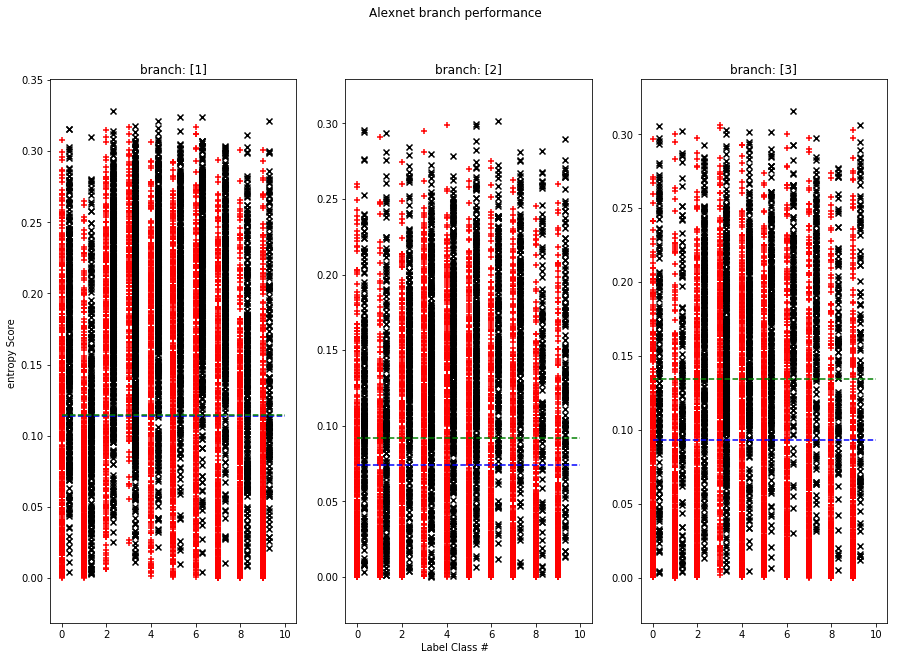

In [102]:
Predictions = displayEvidence_branches(model,test_ds,True)